#01 추천시스템 Collaborative Filtering - Model based approach

https://simonezz.tistory.com/38?category=852348

Collaborive Filtering 은 Memory-based 와 Model-based 로 나뉜다.  
Gradient Descent 와 같은 Optimization 방법으로 parameter 를 업데이트하는 방식이면 Model-based , 그렇지 않으면 Memory-based 이다. 

##1.Matrix Factorization(MF)
" 사용자의 선호도가 몇개의 hidden factors" 로 결정될 수 있다는 것이다. (이러한 factors 들이 embeddings 이라 불린다.)  
Matrix decomposition은 loss funcation과 constraints 에 대한 optimization으로 여겨질 수 있다. 
constraints는 모델의 특성에 따라 선택됨.
예를 들어, Non-negative matrix decomposition은 resultant matrices 가 non-negative 원소들을 갖기를 원하는 경우인데, 여기서는 non-negative 조건이 constraints 가 된다.   


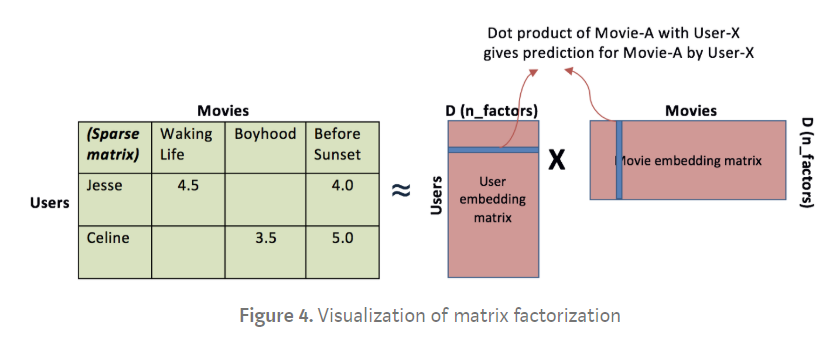

##2. Non-parametric approach(KNN)

Memory-based 알고리즘에서 우리는 예측을 하기 위해, 사용자간의 또는 아이템 간의 유사성을 weights로 사용한다.  
Non-parametric approach와의 차이는 **메모리기반 방법에서의 유사성은 cosine,pearson유사도로 판단**되는 것과 달리 **Non-parametric approach에서는 unsupervised learning model**을 사용한다는 것이다. 또한 Non-parametric approach 는 유사한 사용자들의 수를 k와 같은 수로 한정지어 시스템을 더 확장가능하게 만든다.

##3. Neural Nets / Deep Learning

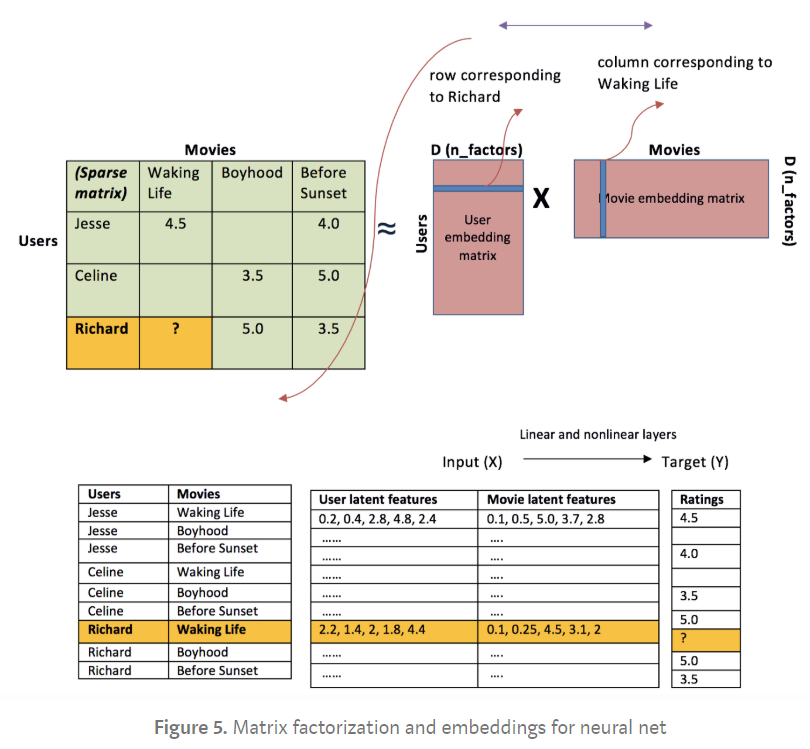

nueral nets을 이용하여 user latent features 와 movie latents features 를 업데이트해 최종 ratings를 구하는 것이 목적이다. 이로써 nueral nets을 이용한 것은 matrix factorization의 확장판이라 생각할 수 있다.  
SVD나 PCA 에서 우리는 우리의 original sparse 행렬을 두 개의 low rank orthogonal matrix로 분리하는데, **neural net에서는 꼭 나눠진 matrix가 orthogonal 일 필요가 없다.** 우리는 그저 embedding matrices의 값들을 업데이트하는 것에 초점을 맞춘다. User latent features와 Movie latent features는 후의 linear, non-linear layers의 input이 된다. 이러한 input 은 relu,sigmoid layers에 넣어져 optimization방법에 따른 weights를 배우게 된다.

이제 Python을 통해 구현해보자!

##Fast.ai 패키지



###1. Shallow Learning

아래는 fastai를 이용해 5줄의 코드로 Probabilistic matrix factorization을 구현한 것이다.

In [ ]:
! pip install fastai

In [ ]:
import pandas as pd
ratings = pd.read_csv('/content/drive/MyDrive/ESAA(22-1)/Week11/movielens/ratings.csv')

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
!pip install fastai==0.7.0
!pip install torchtext==0.2.3

     |████████████████████████████████| 112 kB 5.3 MB/s 
     |████████████████████████████████| 1.5 MB 35.9 MB/s 
ERROR: Could not find a version that satisfies the requirement torch<0.4 (from fastai) (from versions: 1.0.0, 1.0.1, 1.0.1.post2, 1.1.0, 1.2.0, 1.3.0, 1.3.1, 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0)
ERROR: No matching distribution found for torch<0.4
     |████████████████████████████████| 42 kB 651 kB/s 
  Created wheel for torchtext: filename=torchtext-0.2.3-py3-none-any.whl size=40133 sha256=95bb4f537c04415abea047bbe53d02d181859bf6559d15c5eb80b3fd1ca29ea2
  Stored in directory: /root/.cache/pip/wheels/b1/b0/1e/4bece981920cf3250404e58680b4f605a24b7a6827c24360c1
Successfully built torchtext
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0


In [ ]:
def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):
    """ Get a list of index values for Validation set from a dataset
    
    Arguments:
        n : int, Total number of elements in the data set.
        cv_idx : int, starting index [idx_start = cv_idx*int(val_pct*n)] 
        val_pct : (int, float), validation set percentage 
        seed : seed value for RandomState
        
    Returns:
        list of indexes 
    """
    np.random.seed(seed)
    n_val = int(val_pct*n)
    idx_start = cv_idx*n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start+n_val]


In [ ]:
import numpy as np
val_indx = get_cv_idxs(len(ratings))  # index for validation set
wd = 2e-4 # weight decay
n_factors = 50 # n_factors - dimension of embedding matrix (D)

In [ ]:
#build a movie rating dataset
from torch.utils.data import Dataset

In [ ]:
class CollabFilterDataset(Dataset):
    def __init__(self, path, user_col, item_col, ratings):
        self.ratings,self.path = ratings.values.astype(np.float32),path
        self.n = len(ratings)
        (self.users,self.user2idx,self.user_col,self.n_users) = self.proc_col(user_col)
        (self.items,self.item2idx,self.item_col,self.n_items) = self.proc_col(item_col)
        self.min_score,self.max_score = min(ratings),max(ratings)
        self.cols = [self.user_col,self.item_col,self.ratings]

    @classmethod
    def from_data_frame(cls, path, df, user_name, item_name, rating_name):
        return cls(path, df[user_name], df[item_name], df[rating_name])

    @classmethod
    def from_csv(cls, path, csv, user_name, item_name, rating_name):
        df = pd.read_csv(os.path.join(path,csv))
        return cls.from_data_frame(path, df, user_name, item_name, rating_name)

    def proc_col(self,col):
        uniq = col.unique()
        name2idx = {o:i for i,o in enumerate(uniq)}
        return (uniq, name2idx, np.array([name2idx[x] for x in col]), len(uniq))

    def __len__(self): return self.n
    def __getitem__(self, idx): return [o[idx] for o in self.cols]

    def get_data(self, val_idxs, bs):
        val, trn = zip(*split_by_idx(val_idxs, *self.cols))
        return ColumnarModelData(self.path, PassthruDataset(*trn), PassthruDataset(*val), bs)

    def get_model(self, n_factors):
        model = EmbeddingDotBias(n_factors, self.n_users, self.n_items, self.min_score, self.max_score)
        return CollabFilterModel(to_gpu(model))

    def get_learner(self, n_factors, val_idxs, bs, **kwargs):
        return CollabFilterLearner(self.get_data(val_idxs, bs), self.get_model(n_factors), **kwargs)

In [ ]:
#data loader 
import os
path = '/content/drive/MyDrive/ESAA(22-1)/Week11/movielens'
cf = CollabFilterDataset.from_csv(path,'ratings.csv','userId','movieId','rating')

In [ ]:
cf

In [ ]:
from torch import nn
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [ ]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.05,0.05)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_factors, n_users, n_items, min_score, max_score):
        super().__init__()
        self.min_score,self.max_score = min_score,max_score
        (self.u, self.i, self.ub, self.ib) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, users, items):
        um = self.u(users)* self.i(items)
        res = um.sum(1) + self.ub(users).squeeze() + self.ib(items).squeeze()
        return F.sigmoid(res) * (self.max_score-self.min_score) + self.min_score

class CollabFilterLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.mse_loss

class CollabFilterModel(BasicModel):
    def get_layer_groups(self): return self.model

NameError: ignored

In [ ]:
# learner initializes model object
import torch
from torch import optim
learn = cf.get_learner(n_factors, val_indx, bs=64, opt_fn=optim.Adam)

NameError: ignored

In [ ]:
# fitting model with 1e-2 learning rate, 2 epochs, 
# (1 cycle length and 2 cycle multiple for learning rate scheduling)
learn.fit(1e-2,2, wds = wd, cycle_len=1, cycle_mult=2)

###2. Deep Learning

Step 1>

In [ ]:
x = ratings.drop(['rating'],axis=1)
y = ratings['rating'].astype(np.float32)
data = ColumnarModelData.from_data_frame(path, val_indx, x, y, ['userId', 'movieId'], 64)

NameError: ignored

Step 2>

In [ ]:
# nh = dimension of hidden linear layer
# p1 = dropout1
# p2 = dropout2

class EmbeddingNet(nn.Module):
    def __init__(self, n_users, _n_movies, nh = 10, p1 = 0.05, p2= 0.5):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors),
            (n_users,1), (n_movies,1)
        ]]
        
        self.lin1 = nn.Linear(n_factors*2, nh)  # bias is True by default
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p = p1)
        self.drop2 = nn.Dropout(p = p2)
    
    def forward(self, cats, conts): # forward pass i.e.  dot product of vector from movie embedding matrixx
                                    # and vector from user embeddings matrix
        
        # torch.cat : concatenates both embedding matrix to make more columns, same rows i.e. n_factors*2, n : rows
        # u(users) is doing lookup for indexed mentioned in users
        # users has indexes to lookup in embedding matrix. 
        
        users,movies = cats[:,0],cats[:,1]
        u2,m2 = self.u(users) , self.m(movies)
       
        x = self.drop1(torch.cat([u2,m2], 1)) # drop initialized weights
        x = self.drop2(F.relu(self.lin1(x))) # drop 1st linear + nonlinear wt
        r = F.sigmoid(self.lin2(x)) * (max_rating - min_rating) + min_rating               
        return r

Step 3>

In [ ]:
# n_users: count unique users (671), n_movies: count unique movies (9066)
model = EmbeddingNet(n_users, n_movies)

# model.parameters() for back-propagation of weights 
# lr = 1e-3, weight decay = 1e-5 and using adam optimizer 
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=1e-5)

# fitting model,
fit(model, data, 3, opt, F.mse_loss)

# learning rate annealing (for more, check links at the end)
set_lrs(opt, 1e-3)
fit(model, data, 3, opt, F.mse_loss)

#02 Amazon Reviews를 이용한 추천시스템 실습 - surprise패키지 사용

아마존 리뷰 데이터를 이용한 추천시스템 코드에 대해 알아보겠다.

추천시스템은 사용자에게 최적의 아이템을 제안하는 시스템이다.

추천시스템이 풀 수 있는 문제로는 다음과 같다.

1. 유저가 자신에게 아이템을 찾도록 돕는다.

2. 유저의 개입을 증가시킬 수 있다. 예를 들면, 구글 뉴스의 40퍼센트의 클릭 수 증가는 추천시스템으로 인해 발생하였다.

3. 판매자가 아이템들을 올바른 유저에게 제공하도록 한다. 

4. 컨텐츠가 더 개인화되도록 한다. 

 

추천시스템 유형은 다음과 같다.

 

1. Popularity based systems :- 가장 많이 구입되거나 높게 평가된 아이템들을 추천한다. 개인화된 추천이 아니다.  
2. Classification model based:- 사용자의 특성을 이해하고 분류 알고리즘을 사용하여 사용자가 특정 상품에 관심이 있는지 없는지를 결정하여 추천한다.  
3. Content based recommedations:- 유저의 의견보다는 아이템 콘텐츠 정보에 기반하여 추천한다. 사용자가 아이템을 좋아하면 이와 비슷한 다른 아이템도 좋아할 거라는 의견에 기반한다.  
4. Collaberative Filtering:- 유저가 좋아하는 아이템과 비슷한 아이템을 좋아하고 비슷한 취향을 가진 다른사람과 비슷한 아이템을 좋아한다는 아이디어로 추천한다. 유저-유저 추천과 아이템-아이템 추천이 있다.
5. Hybrid Approaches:- Collaborative Filtering과 content-based filtering 등을 합친 방식이다. 각 방식의 단점을 커버한다.
6. Association rule mining :- 거래의 동시 다발성 패턴을 이용하여 아이템들간의 관계를 파악한다.
 

In [1]:
import os
os.getcwd()

'/content'

In [2]:
os.chdir('/content/drive/MyDrive/ESAA(22-1)/Week11/Amazon reviews')

In [3]:
os.getcwd()

'/content/drive/MyDrive/ESAA(22-1)/Week11/Amazon reviews'

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
# from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
electronics_data = pd.read_csv("ratings_Electronics (1).csv",
                               names=['userId', 'productId','Rating','timestamp'])

In [6]:
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


데이터에 대한 대략적인 설명은 다음과 같다.

 



*   userId : 각 유저의 고유한 아이디
*   productId : 각 상품의 고유한 아이디
*   Rating : 각 유저가 각 상품에 대해 평가한 평점
*   timestamp : 평가 시간 (본 알고리즘에서는 무시함)






In [7]:
electronics_data.shape

(7824482, 4)

In [8]:
eletronics_data = electronics_data.iloc[:1048576,0:]
eletronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [9]:
eletronics_data.describe()['Rating'].T

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [10]:
print('max of rating : %d'%(electronics_data.Rating.max()))
print('min of rating : %d'%(electronics_data.Rating.min()))

max of rating : 5
min of rating : 1


##Missing values 수

In [11]:
print('Number of missing values across columns : \n',electronics_data.isnull().sum())

Number of missing values across columns : 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


##Ratings

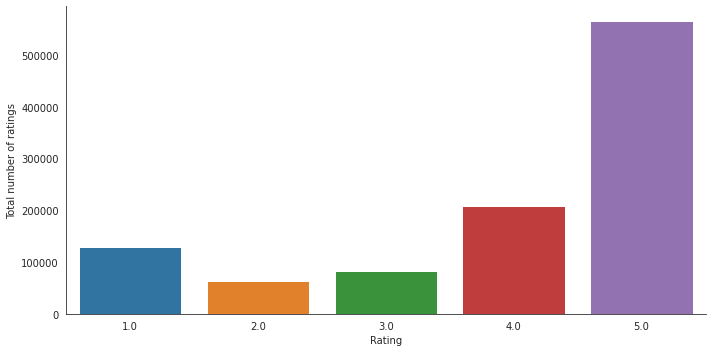

In [12]:
with sns.axes_style('white'):
    g = sns.factorplot('Rating',data = eletronics_data,aspect = 2.0, kind = 'count')
    g.set_ylabels('Total number of ratings')

In [13]:
print('Total data')
print('-'*50)
print('\nTotal num of ratings : ',eletronics_data.shape[0])
print('Total num of Users :', len(np.unique(eletronics_data.userId)))
print('Total sum of products :',len(np.unique(eletronics_data.productId)))

Total data
--------------------------------------------------

Total num of ratings :  1048576
Total num of Users : 786330
Total sum of products : 61894


In [14]:
eletronics_data.drop(['timestamp'],axis=1,inplace=True)

In [15]:
eletronics_data.head()

,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


##Ratings 분석

In [18]:
num_of_rated_products_per_user = eletronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)
num_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [19]:
num_of_rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

거의 모든 user들이 하나의 products 에만 평가한 것을 알 수 있다.

In [20]:
quantiles = num_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01),interpolation='higher')
quantiles

0.00      1
0.01      1
0.02      1
0.03      1
0.04      1
       ... 
0.96      3
0.97      4
0.98      4
0.99      6
1.00    412
Name: Rating, Length: 101, dtype: int64

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

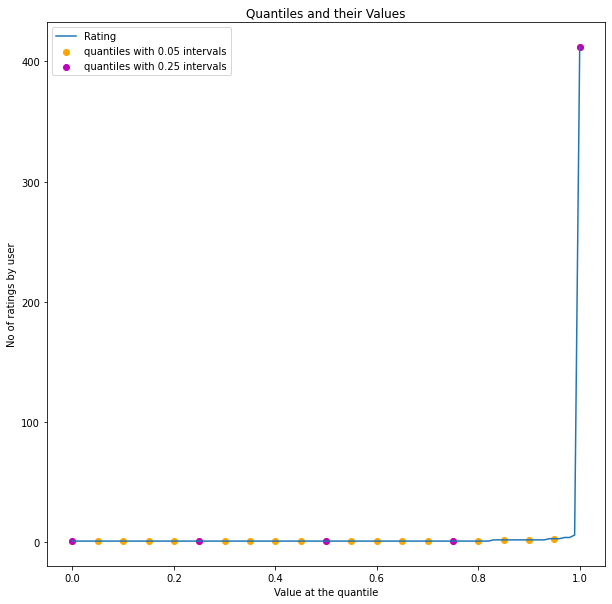

In [21]:
plt.figure(figsize=(10,10))
plt.title('Quantiles and their Values')
quantiles.plot()
#quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5],y=quantiles.values[::5],c='orange',label='quantiles with 0.05 intervals')
#quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25],y=quantiles.values[::25],c='m',label='quantiles with 0.25 intervals')
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [22]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(num_of_rated_products_per_user >=50)))


 No of rated product more than 50 per user : 38



##Popularity Based Recommendation

평가가 50번 이상 된 상품들을 가져옴

In [16]:
new_df = electronics_data.groupby('productId').filter(lambda x:x['Rating'].count()>=50)

In [17]:
new_df.head()

,userId,productId,Rating,timestamp
183,A1BKC6B7YHYTVV,0972683275,4.0,1405382400
184,AWVFSIB42LHKJ,0972683275,4.0,1405209600
185,A36MQBNADRH8YY,0972683275,5.0,1405641600
186,A3SRXMPLAEZ6DP,0972683275,4.0,1405987200
187,A20XXTXWF2TCPY,0972683275,5.0,1405123200


In [18]:
new_df.shape

(5374313, 4)

In [19]:
num_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

In [20]:
num_of_ratings_per_product

productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
              ...  
B002653KNQ       50
B001W81LZ2       50
B0001G6UES       50
B008NC8IB0       50
B0012Y6VQA       50
Name: Rating, Length: 26226, dtype: int64

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

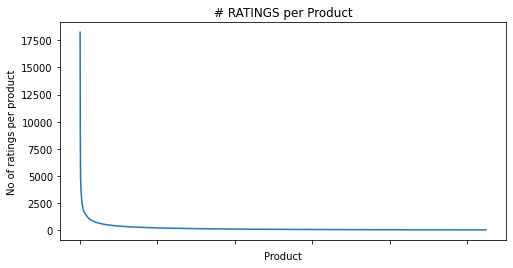

In [29]:
fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(num_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])
plt.show()

평가들을 상품 아이디로 묶고 평점의 평균을 냄

In [30]:
new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [31]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B002E6R7NG    4.980392
B004I763AW    4.966667
B003J9QQWU    4.964286
B0043ZLFXE    4.955556
B000TMFYBO    4.953125
Name: Rating, dtype: float64

평가된 수를 기준으로 내림차순 정렬

In [ ]:
new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

In [33]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [34]:
ratings_mean_count.head()

,Rating
productId,
0972683275,4.470980
1400501466,3.560000
1400501520,4.243902
1400501776,3.884892
1400532620,3.684211


In [35]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [36]:
ratings_mean_count.head()

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [37]:
ratings_mean_count['rating_counts'].max()

18244

<Figure size 432x432 with 0 Axes>

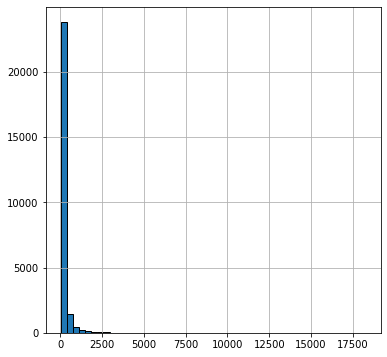

In [38]:
plt.figure(figsize=(6,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 432x432 with 0 Axes>

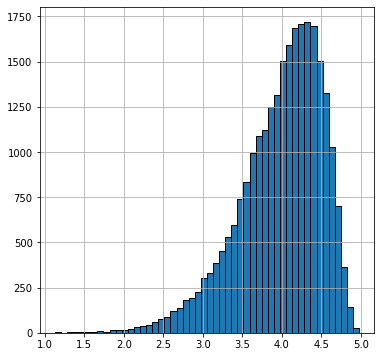

In [39]:
plt.figure(figsize=(6,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

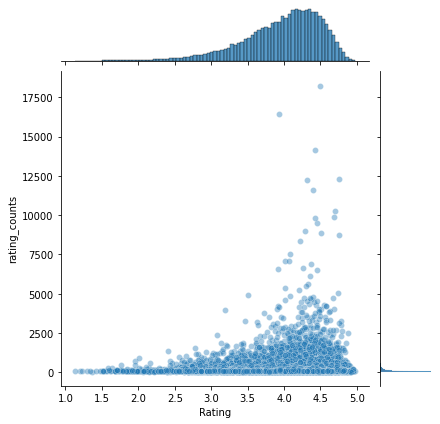

In [40]:
plt.figure(figsize=(6,6))
plt.rcParams['patch.force_edgecolor']=True
sns.jointplot(x='Rating',y='rating_counts',data=ratings_mean_count,alpha=0.4)

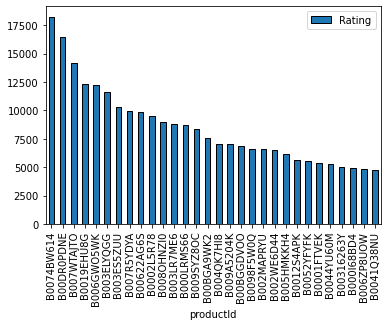

In [41]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating',ascending=False)
most_popular.head(30).plot(kind='bar')

##Collaborative Filtering 이용

In [21]:
!pip3 install surprise

In [22]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

###1) Data 가져오기

In [23]:
new_df.drop(['timestamp'],axis=1,inplace=True)

In [24]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(new_df,reader)

In [25]:
data

###2) Trainset, Testset 으로 나누기

In [26]:
trainset,testset = train_test_split(data,test_size=0.3,random_state=0)

###3) KNN을 이용 trainset 에 파라미터 맞추기

In [ ]:
algo = KNNWithMeans(k=5,simp_options = {'name':'person_baseline','user_based':False})
algo.fit(trainset)

Computing the msd similarity matrix...


###4) Test accuracy 측정

In [ ]:
test_pred = algo.test(testset)

In [ ]:
print('Item-based Model: Test Set')
accuracy.rmse(test_pred,verbose=True)

##Model-based collaborative filtering system

In [48]:
new_df1 = new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating',index='userId',columns='productId',fill_value=0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
ratings_matrix.shape

(9832, 76)

In [50]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
X.shape

(76, 9832)

In [52]:
X.index

Index(['0972683275', '1400501466', '1400501520', '1400501776', '1400532620',
       '1400532655', '140053271X', '1400532736', '1400599997', '1400698987',
       '3744295508', '6301977173', '7214047977', '8862935293', '9573212919',
       '9575871979', '9625993428', '9888002198', '9966694544', '9983891212',
       '9984984354', '9985511476', 'B000001OM4', 'B000001OM5', 'B000001OMI',
       'B000001ON6', 'B00000DM9W', 'B00000IGBF', 'B00000J05A', 'B00000J061',
       'B00000J08Q', 'B00000J0D2', 'B00000J0D5', 'B00000J0D8', 'B00000J1EJ',
       'B00000J1EP', 'B00000J1EQ', 'B00000J1F3', 'B00000J1GA', 'B00000J1QK',
       'B00000J1QR', 'B00000J1SC', 'B00000J1TX', 'B00000J1U8', 'B00000J1UQ',
       'B00000J1V3', 'B00000J1V5', 'B00000J3NF', 'B00000J3Q7', 'B00000J3UJ',
       'B00000J434', 'B00000J4EY', 'B00000J4FS', 'B00000J4GE', 'B00000J6WY',
       'B00000JBAT', 'B00000JBHP', 'B00000JBPB', 'B00000JCT8', 'B00000JCTO',
       'B00000JD34', 'B00000JDF5', 'B00000JDF6', 'B00000JDHV', 'B00000JFE3',

In [53]:
X1 = X

In [54]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [55]:
decomposed_matrix

array([[ 1.48104508e+02, -1.54577640e-01,  2.45526948e-02,
         3.17094631e-04, -1.34183138e-01,  9.59460388e-05,
         4.59869595e-02, -6.35714409e-04,  4.64913934e-04,
        -8.23072454e-02],
       [ 6.65590141e-04,  1.28919240e+00,  1.49277641e+00,
         1.99856966e-01,  7.51150995e-03, -8.43899233e-03,
         3.27522166e-02, -7.82739810e-02,  6.12835906e+01,
        -8.51027704e-01],
       [ 4.02960618e-05,  1.14548273e-01,  3.21384717e-01,
         1.46992448e-02,  1.81616631e-02, -2.29120064e-02,
         3.58011585e-02, -6.50995001e-02,  9.71792326e-01,
         2.32733732e-01],
       [ 6.14985689e-04,  7.65779736e-01,  4.50984837e-01,
         3.75768385e-02,  2.80821738e-02, -2.40624278e-02,
        -1.01182577e-02,  4.97630291e-02,  5.01421925e+00,
         4.93374246e-01],
       [ 5.80172724e-04,  8.18745560e-01,  1.07452252e+00,
         3.12114331e-02,  2.57894030e-02,  4.17771527e-02,
        -3.84556365e-02, -2.45205579e-01,  1.20690152e+00,
        -3.

In [56]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [57]:
X.index[75]

'B00000K135'

In [58]:
i = X.index[75]

product_names = list(X.index)
product_ID = product_names.index(i) #index 구하기
product_ID

75

In [59]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

In [60]:
correlation_product_ID

array([-0.05094787, -0.06074126,  0.19136937,  0.03027853, -0.11321668,
        0.02826369,  0.00364324,  0.11224964, -0.44798301,  0.71420188,
        0.89554947,  0.88730644, -0.38531354, -0.27297934, -0.90762329,
       -0.79524206, -0.83477923,  0.58274756, -0.19878044,  0.8269698 ,
       -0.34467798, -0.10316757, -0.89573741, -0.50523639, -0.64242034,
       -0.85996197,  0.04754841, -0.49679807,  0.84230204, -0.6404144 ,
       -0.42508286,  0.77719331, -0.84292371, -0.74153177,  0.24133441,
        0.24146787,  0.3189711 , -0.32810965, -0.01802879, -0.84610678,
       -0.21483839, -0.45665589,  0.30633654, -0.94683513,  0.87024622,
        0.11060349,  0.0276846 , -0.53125563, -0.45157266,  0.73596147,
       -0.32708001, -0.17035102, -0.36623536,  0.33204161,  0.31348789,
       -0.95449842,  0.8387973 , -0.60527077, -0.62901152,  0.54015483,
       -0.41348057, -0.07817322, -0.70583534,  0.23153325, -0.57147104,
        0.18865065, -0.71602146, -0.00498692, -0.06735249,  0.03

In [62]:
Recommend = list(X.index[correlation_product_ID > 0.65]) #피어슨 상관계수가 0.65보다 큰 상품들의 index의 list return
Recommend.remove(i)  #이미 구입한 상품은 뺀다.
Recommend[0:24]  #상위 24개 추천

['1400698987',
 '3744295508',
 '6301977173',
 '9983891212',
 'B00000J05A',
 'B00000J0D2',
 'B00000J1UQ',
 'B00000J3UJ',
 'B00000JBHP']

In [63]:
Recommend

['1400698987',
 '3744295508',
 '6301977173',
 '9983891212',
 'B00000J05A',
 'B00000J0D2',
 'B00000J1UQ',
 'B00000J3UJ',
 'B00000JBHP']